In [4]:
library(tidyverse)
library(fixest)
#install.packages("MatchIt")
library(MatchIt)


In [6]:
data <- read_csv("wms_work.csv")

data$industry <- as.factor(data$industry)

Rows: 8439 Columns: 52
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (6): cty, country, ownership, mne_cty, competition, countrycode
dbl (39): firmid, wave, sic, management, operations, monitor, target, people...
lgl  (7): compet_weak, compet_moder, compet_strong, age_young, age_old, age_...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [7]:
ols1 <- feols(management ~ foundfam_owned, data = data)
summary(ols1)

OLS estimation, Dep. Var.: management
Observations: 8,439
Standard-errors: IID 
                Estimate Std. Error  t value  Pr(>|t|)    
(Intercept)     3.047261   0.008977 339.4667 < 2.2e-16 ***
foundfam_owned -0.365659   0.013326 -27.4386 < 2.2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 0.609413   Adj. R2: 0.081816

In [8]:
ols2 <- feols(management ~ foundfam_owned + degree_nm + degree_nm_sq + compet_moder + compet_strong +
                lnemp + age_young + age_old + age_unknown + industry + countrycode, data=data)
summary(ols2)


OLS estimation, Dep. Var.: management
Observations: 8,439
Standard-errors: IID 
                   Estimate Std. Error    t value   Pr(>|t|)    
(Intercept)        1.745582   0.049548  35.229904  < 2.2e-16 ***
foundfam_owned    -0.194388   0.012997 -14.956541  < 2.2e-16 ***
degree_nm          1.415766   0.094189  15.031125  < 2.2e-16 ***
degree_nm_sq      -1.477829   0.136477 -10.828415  < 2.2e-16 ***
compet_moderTRUE   0.019139   0.017492   1.094163 2.7391e-01    
compet_strongTRUE -0.013722   0.014737  -0.931097 3.5183e-01    
lnemp              0.166355   0.005964  27.895152  < 2.2e-16 ***
age_youngTRUE      0.002582   0.013866   0.186252 8.5225e-01    
age_oldTRUE       -0.003096   0.021615  -0.143255 8.8609e-01    
age_unknownTRUE   -0.081930   0.022128  -3.702492 2.1486e-04 ***
industry21        -0.173995   0.145395  -1.196702 2.3146e-01    
industry22        -0.101684   0.031416  -3.236689 1.2139e-03 ** 
industry23        -0.059654   0.035362  -1.686957 9.1649e-02 .  
industry24

In [9]:
etable( ols1,ols2,
        fitstat = c('n','r2'),
        keep = c('Constant', 'foundfam_owned'),
        headers = c("no confounders", "with confounders"))


,,ols1,ols2
,<chr>,<chr>,<chr>
1,,no confounders,with confounders
2,Dependent Var.:,management,management
3,,,
4,Constant,3.047*** (0.0090),1.746*** (0.0495)
5,foundfam_owned,-0.3657*** (0.0133),-0.1944*** (0.0130)
6,_______________,___________________,___________________
7,S.E. type,IID,IID
8,Observations,"8,439","8,439"
9,R2,0.08192,0.28571


In [10]:
# employment: We create 5 bins based on quintiles (roughly 20% of the obs in each bin)
# age: 4 categories (the original ones)
# degree_nm: 4 bins (0s and 3 bins based on the percentiles)
summary(data$degree_nm)
summary(data$degree_nm[data$degree_nm>0])
# compet: 3 categories (the original ones)
table(data$competition)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  0.0500  0.1046  0.1200  1.0000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0100  0.0500  0.1000  0.1538  0.2000  1.0000 


  0 competitors 1-4 competitors 10+ competitors 5-9 competitors 
             54            1954            4583            1848 

In [11]:
data <- data %>%
  mutate(
    empbin5 = cut(emp_firm, quantile(emp_firm, seq(0,1,0.2)), include.lowest = TRUE, right = FALSE),
    agecat4 = (age_young == TRUE) + 2*(age_mid == TRUE) + 3*(age_old == TRUE) + 4*(age_unknown == TRUE),
    degree_nm_bin4 = cut(degree_nm, c(0,0.001,0.05,0.20,1.01), right= FALSE),
    compet3 = recode(competition, "0 competitors" = "weak", "1-4 competitors" = "weak", "5-9 competitors" = "moderate", "10+ competitors" = "strong")
  )


In [12]:
table(data$empbin5)
table(data$agecat4)
table(data$degree_nm_bin4)
table(data$compet3)
table(data$industry)
table(data$countrycode)



   [50,120)   [120,200)   [200,349)   [349,760) [760,5e+03] 
       1595        1650        1818        1687        1689 


   1    2    3    4 
3131 3241  848 1219 


   [0,0.001) [0.001,0.05)   [0.05,0.2)   [0.2,1.01) 
        2700         1331         2796         1612 


moderate   strong     weak 
    1848     4583     2008 


  20   21   22   23   24   25   26   27   28   29   30   31   32   33   34   35 
1089   14  446  319  272  224  377  306  809   66  532  118  383  424  710  803 
  36   37   38   39 
 597  485  253  212 


 ar  au  br  ca  cl  cn  es  fr  gb  ge  gr  in  ir  it  jp  mx  ni  nz  po  pt 
394 386 751 340 390 469 201 332 724 331 399 553 151 392 110 392 107 140 167 185 
 sg  sw  tr  us 
264 228 329 704 

In [13]:
data_agg <- data %>%
  group_by(empbin5, degree_nm_bin4, agecat4, compet3, industry, countrycode) %>%
  summarise(
    n = n(), n0 = sum(1-foundfam_owned), n1 = sum(foundfam_owned),
    y0 = sum(management*(foundfam_owned == 0))/sum(1-foundfam_owned), 
    y1 = sum(management*(foundfam_owned == 1))/sum(foundfam_owned)
  ) %>%
  ungroup()


`summarise()` has grouped output by 'empbin5', 'degree_nm_bin4', 'agecat4',
'compet3', 'industry'. You can override using the `.groups` argument.


In [14]:
# Number of combinations with control and without treated: (3622)
nrow(data_agg[data_agg$n0 > 0 & data_agg$n1 == 0, ])
# Number of combinations with treated without control: (2886)
nrow(data_agg[data_agg$n0 == 0 & data_agg$n1 > 0, ])
# Number of combinations with control and treated: (468)
nrow(data_agg[data_agg$n0 > 0 & data_agg$n1 > 0, ])
# Number of firms which will be included: (1207)
sum(data_agg$n[data_agg$n0 > 0 & data_agg$n1 > 0])


[1] 3622

[1] 2886

[1] 468

[1] 1207

In [15]:
data_agg %>%
  filter(n0>0 & n1>0) %>%
  summarise(ATE = weighted.mean(y1-y0, n), ATET = weighted.mean(y1-y0, n1))


ATE,ATET
<dbl>,<dbl>
-0.1553368,-0.1457565


In [16]:
data_exact <- data %>% 
  select(management, foundfam_owned, degree_nm_bin4, agecat4,
         compet3, empbin5, 
         industry, countrycode) %>%
  na.omit()


In [17]:
formula_exact <- as.formula(foundfam_owned ~ empbin5 + degree_nm_bin4 + agecat4 +
                              compet3 + industry + countrycode)

mod_match <- matchit(formula_exact, 
                     data = data_exact, 
                     method = 'exact', estimand = 'ATE') 
# With estimand = 'ATT' we can calculate the ATT, too.


In [19]:
summary(mod_match)


Call:
matchit(formula = formula_exact, data = data_exact, method = "exact", 
    estimand = "ATE")

Summary of Balance for All Data:
                           Means Treated Means Control Std. Mean Diff.
empbin5[50,120)                   0.2270        0.1575          0.1770
empbin5[120,200)                  0.2249        0.1711          0.1351
empbin5[200,349)                  0.2254        0.2072          0.0443
empbin5[349,760)                  0.1875        0.2102         -0.0568
empbin5[760,5e+03]                0.1353        0.2540         -0.3033
degree_nm_bin4[0,0.001)           0.3596        0.2870          0.1558
degree_nm_bin4[0.001,0.05)        0.1724        0.1456          0.0734
degree_nm_bin4[0.05,0.2)          0.3118        0.3475         -0.0759
degree_nm_bin4[0.2,1.01)          0.1562        0.2200         -0.1638
agecat4                           1.9433        2.0807         -0.1350
compet3moderate                   0.2092        0.2271         -0.0434
compet3strong 

In [21]:
data_match <- match.data(mod_match)

reg_match <- feols(management ~ foundfam_owned, 
                   data = data_match, 
                   weights = data_match$weights
)

reg_match

OLS estimation, Dep. Var.: management
Observations: 1,207
Weights: data_match$weights
Standard-errors: IID 
                Estimate Std. Error  t value   Pr(>|t|)    
(Intercept)     2.887899   0.024669 117.0656  < 2.2e-16 ***
foundfam_owned -0.155337   0.034758  -4.4691 8.5942e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 0.603262   Adj. R2: 0.015488

In [22]:
data_pscore <- data %>% 
  select(management, foundfam_owned, degree_nm, degree_nm_sq,
         compet_moder, compet_strong, 
         lnemp, age_young, age_old, age_unknown,
         industry, countrycode) %>%
  na.omit()


In [23]:
formula_pscore <- as.formula(foundfam_owned ~ degree_nm + degree_nm_sq +
                               compet_moder + compet_strong + 
                               lnemp + age_young + age_old + age_unknown +
                               industry + countrycode)


In [29]:
mod_match <- matchit(formula_pscore, 
                     data = data_pscore, 
                     method = 'nearest', distance = 'logit', replace=TRUE)

summary(mod_match)


Call:
matchit(formula = formula_pscore, data = data_pscore, method = "nearest", 
    distance = "logit", replace = TRUE)

Summary of Balance for All Data:
                  Means Treated Means Control Std. Mean Diff. Var. Ratio
distance                 0.5509        0.3730          0.9015     1.1351
degree_nm                0.0882        0.1182         -0.2070     0.7003
degree_nm_sq             0.0287        0.0439         -0.1674     0.5499
compet_moderTRUE         0.2092        0.2271         -0.0441          .
compet_strongTRUE        0.5761        0.5156          0.1225          .
lnemp                    5.5159        5.8808         -0.3745     0.7859
age_youngTRUE            0.3761        0.3668          0.0191          .
age_oldTRUE              0.0765        0.1204         -0.1650          .
age_unknownTRUE          0.1214        0.1636         -0.1289          .
industry20               0.1473        0.1139          0.0943          .
industry21               0.0013        0.

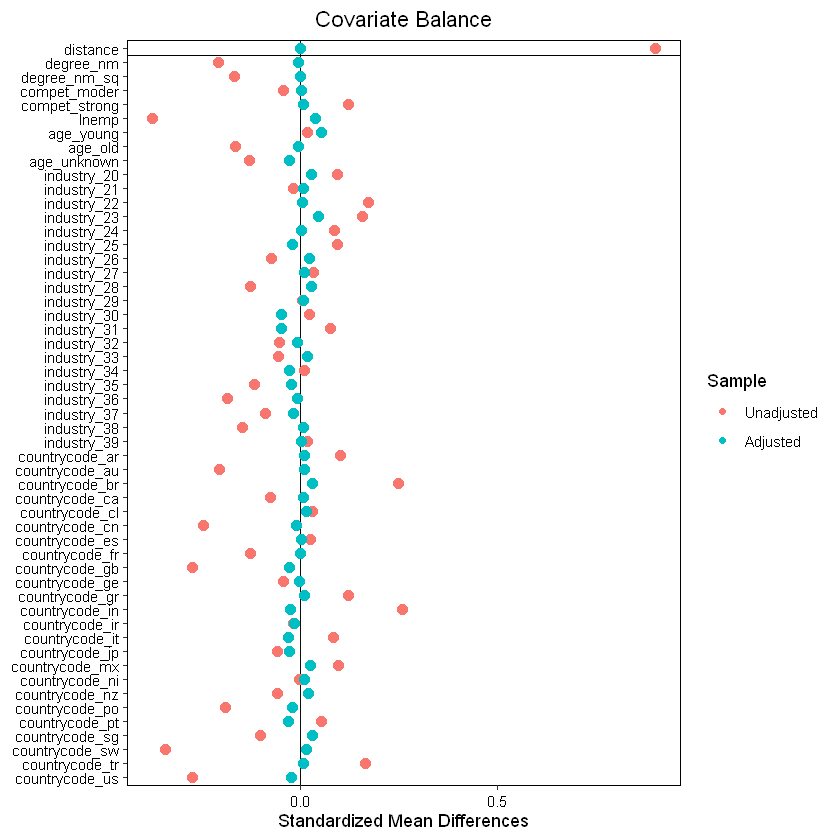

In [37]:
library(cobalt)
love.plot(mod_match, binary = "std")



In [30]:
summary(mod_match)$sum.matched


,Means Treated,Means Control,Std. Mean Diff.,Var. Ratio,eCDF Mean,eCDF Max,Std. Pair Dist.
distance,0.550908132,0.550904345,1.918939e-05,0.9993372,0.0002420345,0.0057456255,0.001340194
degree_nm,0.088221468,0.089051972,-5.738015e-03,1.0091874,0.0070288797,0.0323844346,0.819994836
degree_nm_sq,0.028726404,0.028665657,6.715267e-04,0.8526031,0.0070288797,0.0323844346,0.538597909
compet_moderTRUE,0.209193001,0.207887177,3.210523e-03,NA,0.0013058240,0.0013058240,0.812262366
compet_strongTRUE,0.576129538,0.571950901,8.455864e-03,NA,0.0041786367,0.0041786367,0.961854484
lnemp,5.515924296,5.478975657,3.792193e-02,0.9713092,0.0094174293,0.0394358840,1.010016447
age_youngTRUE,0.376077305,0.349960825,5.391513e-02,NA,0.0261164795,0.0261164795,0.952141245
age_oldTRUE,0.076521285,0.078088274,-5.894695e-03,NA,0.0015669888,0.0015669888,0.530522517
age_unknownTRUE,0.121441630,0.130582397,-2.798424e-02,NA,0.0091407678,0.0091407678,0.624448410
industry20,0.147296944,0.137633847,2.726595e-02,NA,0.0096630974,0.0096630974,0.674279489


In [27]:
data_match <- match.data(mod_match)

reg_match <- feols(management ~ foundfam_owned, 
                   data = data_match, 
                   weights = data_match$weights
)

reg_match


OLS estimation, Dep. Var.: management
Observations: 5,715
Weights: data_match$weights
Standard-errors: IID 
                Estimate Std. Error  t value  Pr(>|t|)    
(Intercept)     2.877665   0.014121 203.7811 < 2.2e-16 ***
foundfam_owned -0.196063   0.017252 -11.3646 < 2.2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 0.613156   Adj. R2: 0.021936